In [1]:
# Settings

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix

import lime
import lime.lime_tabular
from pdpbox import pdp, info_plots
from sklearn.tree import plot_tree
import shap

# do not display LGBM categorical override warning 
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# define path
my_path = "/Users/meikeepauline/Desktop/MA/"

# define variables
target_variable = ['DEFAULT_12M']
model_variables = ['fico','mi_pct','cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','channel','prop_type','loan_purpose','orig_loan_term','cd_ppty_val_type','us_reg','flag_fthb','cnt_borr','flag_mi','orig_loan_term_3grp','flag_orig_loan_term_HEQ_360M']
model_variables_ind = ['fico','mi_pct','cnt_units','cltv','dti','orig_upb','ltv','orig_loan_term','flag_fthb','cnt_borr','flag_mi','flag_orig_loan_term_HEQ_360M'\
                    ,'loan_purpose__C','loan_purpose__N','loan_purpose__P','channel__9','channel__B','channel__C','channel__R','channel__T','cd_ppty_val_type__1','cd_ppty_val_type__2','cd_ppty_val_type__3','cd_ppty_val_type__9','us_reg__Midwest','us_reg__Northeast','us_reg__Other','us_reg__South','us_reg__West','occpy_sts__I','occpy_sts__P']
all_variables = model_variables+target_variable

In [2]:
#Import dataset and print overview

df_csv = pd.read_csv(my_path+"DEV_SAMPLE5Y_FINAL.CSV", parse_dates=[3], dayfirst=True, dtype={'GROUP2': 'str', 'zipcode': 'str', 'cd_ppty_val_type': 'str', 'cd_zero_bal': 'str', 'flag_sc_raw': 'str', 'id_loan_preharp': 'str','ind_harp_raw': 'str', 'zero_bal_delq_sts': 'str'})

print(df_csv.head())          # print first 5 rows
print(df_csv.info())          # print information of data (null, type)

   Selected  DEFAULT_12M GROUP2      DATUM       id_loan  loan_age_noMod  \
0         1            0   2017 2017-12-01  F17Q40279565              63   
1         1            0   2017 2017-12-01  F17Q40215556              63   
2         1            0   2017 2017-12-01  F17Q40319954              34   
3         1            0   2017 2017-12-01  F17Q40189974              63   
4         1            0   2017 2017-12-01  F17Q40162839              63   

               KEEP_FLAG  fico  dt_first_pi flag_fthb_raw  ...  \
0  1;More than 12 months   681       201712             N  ...   
1  1;More than 12 months   716       201712             N  ...   
2  1;More than 12 months   778       201712             N  ...   
3  1;More than 12 months   797       201712             N  ...   
4  1;More than 12 months   717       201712             Y  ...   

   us_reg__Midwest  us_reg__Northeast  us_reg__Other  us_reg__South  \
0                0                  0              0              0   
1   

In [3]:
# Split data into Training and Test data set for model variables and target 

temp = df_csv[(df_csv.Selected == 1)]
X_train = temp[model_variables_ind]
y_train = temp[target_variable]

temp = df_csv[(df_csv.Selected == 0)]
X_test = temp[model_variables_ind]
y_test = temp[target_variable]

inp_data = df_csv[model_variables_ind]
out_data = df_csv[target_variable]

df = df_csv[target_variable+model_variables_ind]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print("DR of training sample: ", X_train["DEFAULT_12M"].mean())
#print("DR of test sample: ", X_test["DEFAULT_12M"].mean())

(7650336, 31) (3278709, 31) (7650336, 1) (3278709, 1)


In [4]:
# Convert the data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [5]:
# Set parameters for LightGBM
params = {
# Settings for Random forest and others
    'random_state' : [500],                                                                 # seed
    'boosting_type' : ['rf'],                                                               # Random Forest
    'objective' : ['binary'],                                                               # Binary classification problem
    'feature_fraction': 0.9,                                                                # Fraction of features to be used in each boosting round
    'bagging_fraction': 0.8,                                                                # Fraction of data to be used in each boosting round
    'bagging_freq': 5,                                                                      # Frequency for bagging
}

In [6]:
rf = lgb.LGBMRegressor(**params)
rf.fit(X_train, y_train)

In [8]:
# Make predictions on the test set
y_pred = pd.DataFrame(rf.predict(X_test))

In [9]:
for threshold in np.arange(0.0, 0.1, 0.005): 
    y_pred_f1 = np.where(y_pred > threshold, 1, 0)
    f1 = f1_score(y_test, y_pred_f1)
    print('Threshold:', threshold, 'F1-score:', f1)

Threshold: 0.0 F1-score: 0.019021258894124236
Threshold: 0.005 F1-score: 0.02229510843046399
Threshold: 0.01 F1-score: 0.035511441166366474
Threshold: 0.015 F1-score: 0.04387743292645567
Threshold: 0.02 F1-score: 0.04992351135592782
Threshold: 0.025 F1-score: 0.0530549731602504
Threshold: 0.03 F1-score: 0.05590962398875644
Threshold: 0.035 F1-score: 0.057593688362919136
Threshold: 0.04 F1-score: 0.05929851439765921
Threshold: 0.045 F1-score: 0.06030672973392829
Threshold: 0.05 F1-score: 0.06093493567684896
Threshold: 0.055 F1-score: 0.060705520348730724
Threshold: 0.06 F1-score: 0.06041698741582867
Threshold: 0.065 F1-score: 0.058858715157315465
Threshold: 0.07 F1-score: 0.05820491565880014
Threshold: 0.075 F1-score: 0.05698580963598632
Threshold: 0.08 F1-score: 0.05567583526054224
Threshold: 0.085 F1-score: 0.05432259747033511
Threshold: 0.09 F1-score: 0.053227478583510665
Threshold: 0.095 F1-score: 0.05229442126847204


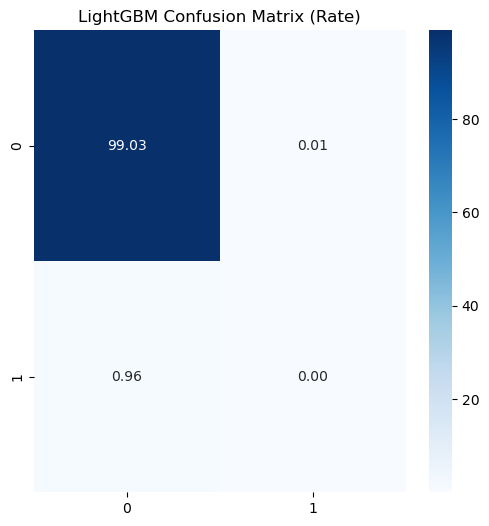

In [10]:
y_pred.rename(columns={y_pred.columns[0]: "PD_PRED" }, inplace = True)
y_pred['DEFAULT_12M_PRED'] = np.where(y_pred["PD_PRED"] > 0.5, 1, 0)

plt.figure(figsize=(6,6))
cf_matrix = confusion_matrix(y_test, y_pred["DEFAULT_12M_PRED"])
sns.heatmap((cf_matrix / np.sum(cf_matrix)*100), annot = True, fmt=".2f", cmap="Blues")
plt.title("LightGBM Confusion Matrix (Rate)")
plt.show()

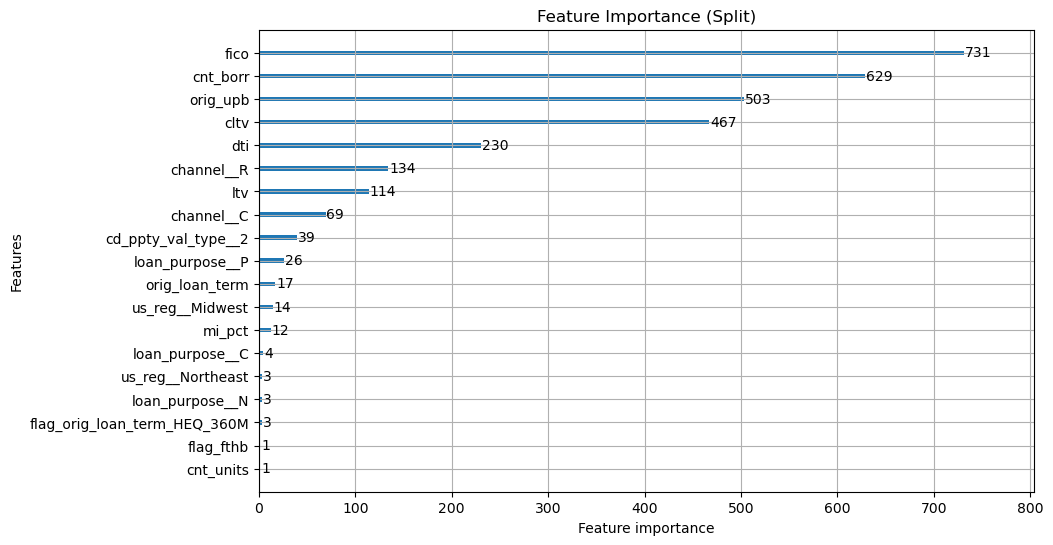

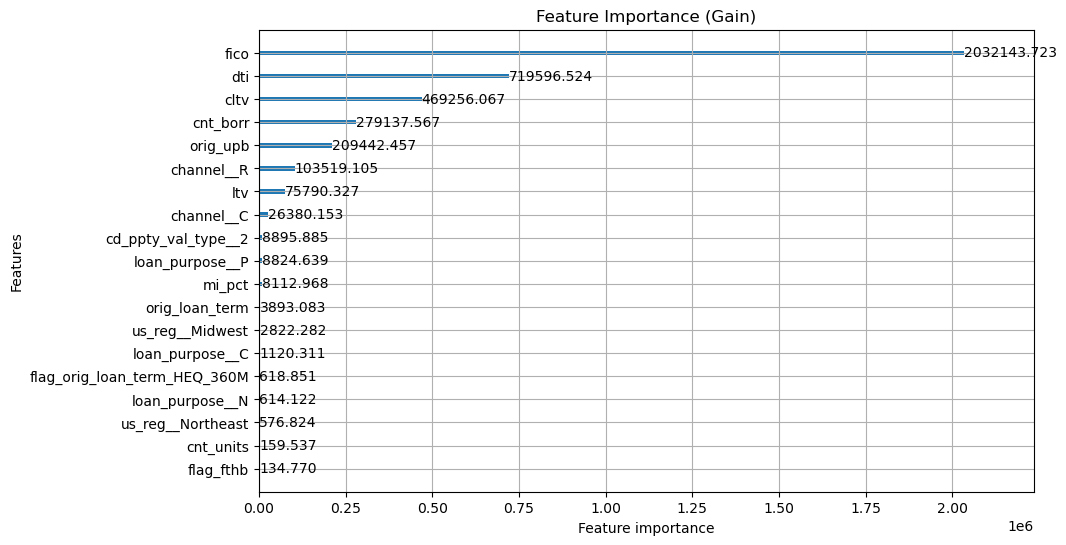

In [11]:
# Feature Importance Analysis
lgb.plot_importance(rf, importance_type='split', figsize=(10, 6), title='Feature Importance (Split)')
plt.show()

lgb.plot_importance(rf, importance_type='gain', figsize=(10, 6), title='Feature Importance (Gain)')
plt.show()

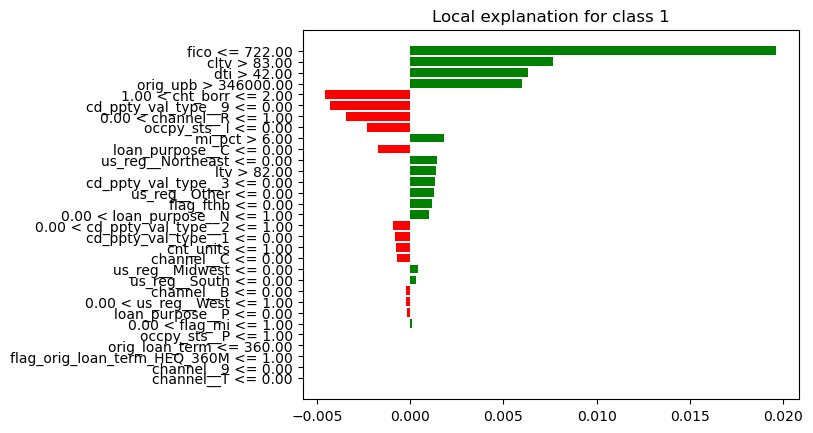

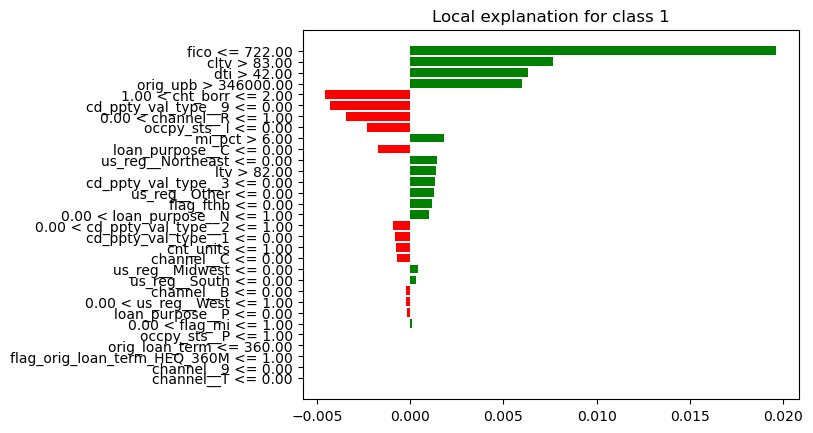

In [12]:
# this is required as LIME requires class probabilities in case of classification example
# LightGBM directly returns probability for class 1 by default 

def prob(data):
    return np.array(list(zip(1-rf.predict(data),rf.predict(data))))

# LIME (Local Interpretable Model-agnostic Explanations)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=True)

# Choose a random instance for explanation
instance_idx = 0
instance = X_test.iloc[[instance_idx]].values[0]
exp = explainer.explain_instance(instance, prob, num_features=len(X_test.columns))

exp.as_pyplot_figure()
exp.show_in_notebook(show_all=False)

<Figure size 2000x1000 with 0 Axes>

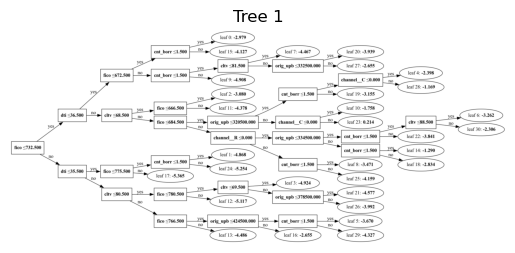

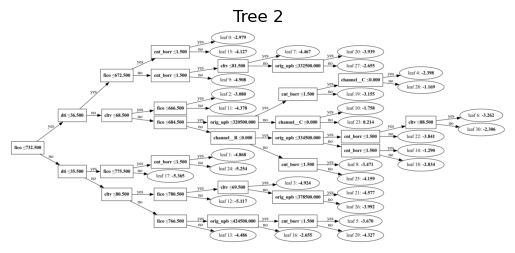

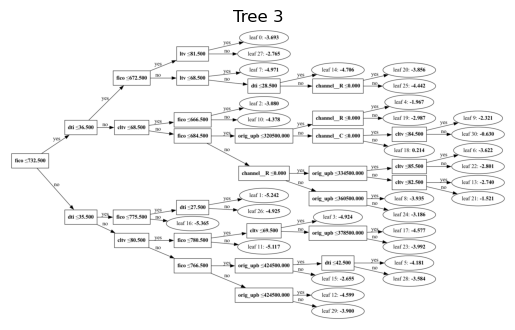

In [13]:
# Visualize a few decision trees in the random forest
plt.figure(figsize=(20, 10))
for i in range(3):  # Display the first 3 trees
    lgb.plot_tree(rf, tree_index=i)
    plt.title(f'Tree {i+1}')
plt.show()

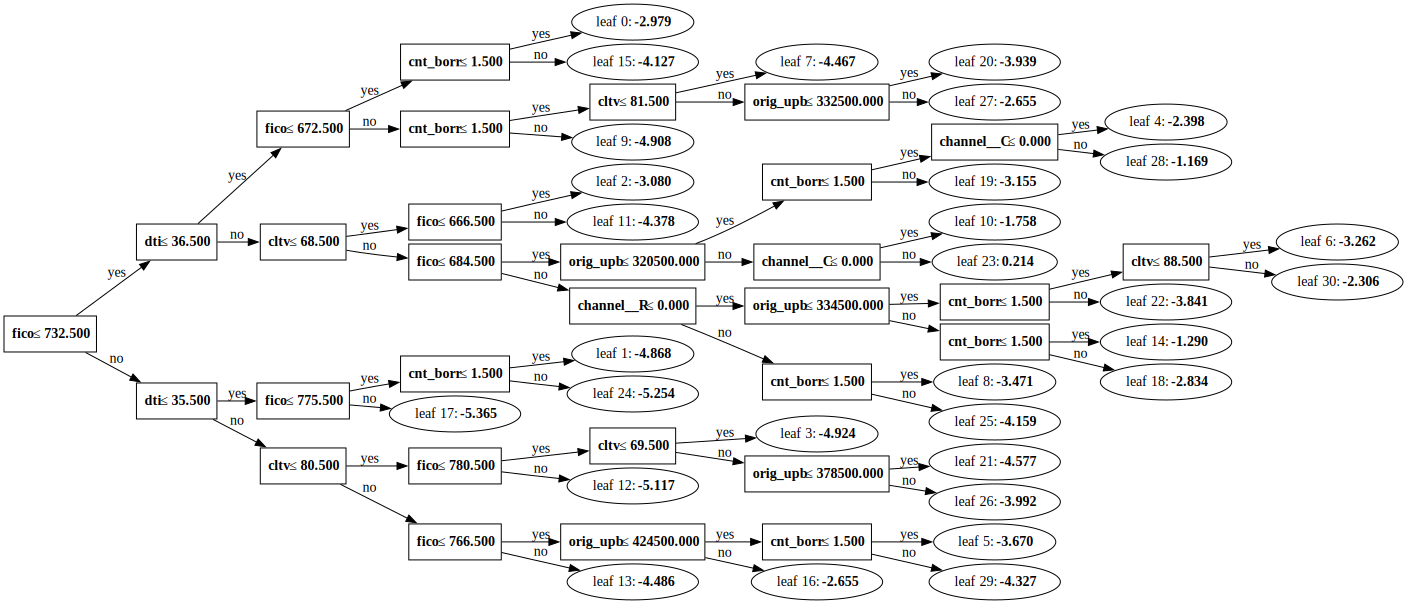

<Figure size 2000x1000 with 0 Axes>

In [14]:
plt.figure(figsize=(20, 10))
graph = lgb.create_tree_digraph(rf)
graph

In [26]:
# SHAP (SHapley Additive exPlanations)
explainer_shap = shap.TreeExplainer(rf)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=['0', '1'])
plt.show()

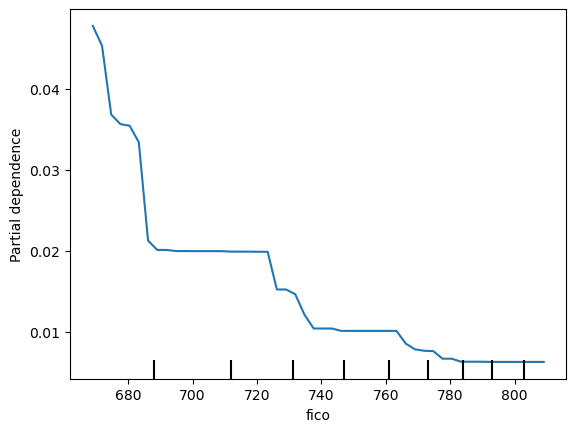

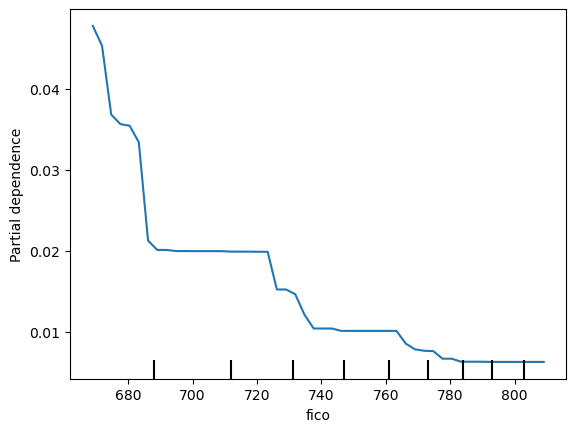

In [16]:
from sklearn.inspection import PartialDependenceDisplay

# Create Partial Dependence Display
disp = PartialDependenceDisplay.from_estimator(rf, X_test, features=['fico'], grid_resolution=50)
disp.plot()
plt.show()

In [40]:
from sklearn import metrics

def auc_gini(Modelname, y_DEFAULT_12M, y_pred_PD):
    fpr, tpr, _ = metrics.roc_curve(y_DEFAULT_12M, y_pred_PD)
    auc = round(metrics.roc_auc_score(y_DEFAULT_12M, y_pred_PD), 4)
    gini = 2 * auc - 1
    plt.plot(fpr,tpr,label=str(Modelname) + ", AUC=" + str(round(auc,5)) + ", GINI=" + str(round(gini,5)))
    
    print(str(Modelname), "GINI: ", str(gini))

Baseline GINI:  0.4554
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Refined GINI:  0.44120000000000004


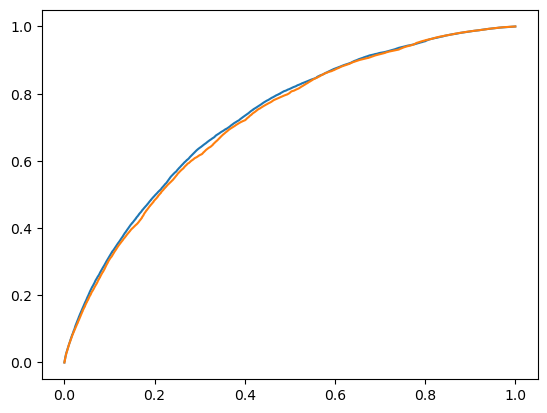

In [34]:
#rf = lgb.LGBMRegressor(**params)
#rf.fit(X_train, y_train)

y_pred = pd.DataFrame(rf.predict(X_test))
y_pred.rename(columns={y_pred.columns[0]: "PD_PRED" }, inplace = True)

params2 = {
    'reg_lambda': 1.2, 
    'reg_alpha': 1.2, 
    'random_state': 500, 
    'objective': 'binary', 
    'num_leaves': 16, 
    'n_estimators': 1400, 
    'max_depth': 6, 
    'learning_rate': 0.01, 
    'boosting_type': 'rf',
    'feature_fraction': 0.9,  # Fraction of features to be used in each boosting round
    'bagging_fraction': 0.8,  # Fraction of data to be used in each boosting round
    'bagging_freq': 5  # Frequency for bagging
}
rf2 = lgb.LGBMRegressor(**params2)
rf2.fit(X_train, y_train)

y_pred = pd.DataFrame(rf2.predict(X_test))
y_pred.rename(columns={y_pred.columns[0]: "PD_PRED" }, inplace = True)

auc_gini('Baseline', y_test, y_pred["PD_PRED"])
auc_gini('Refined', y_test, y_pred["PD_PRED"])
plt.legend()

In [23]:
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)

X_trainf, X_val, y_trainf, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

randParams = {

# Hyperparameters to be changed
    'learning_rate': [0.005, 0.01],                                                         # Boosting learning rate
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],               # Number of boosted trees to fit.
    'num_leaves': [6,8,12,16],                                                              # large num_leaves helps improve accuracy but might lead to over-fitting
    'max_depth': [6,8,12,16],                                                               # Maximum tree depth for base learners, <=0 means no limit.
    #'max_bin':[255, 510],                                                                  # large max_bin helps improve accuracy but might slow down training progress
    'reg_alpha' : [1,1.2],                                                                  # L1 regularization term on weights
    'reg_lambda' : [1,1.2,1.4],                                                             # L2 regularization term on weights.

# Settings for Random forest and others
    'random_state' : [500],                                                                 # seed
    'boosting_type' : ['rf'],                                                               # Random Forest
    'objective' : ['binary'],
    'feature_fraction': 0.9,                                                                # Fraction of features to be used in each boosting round
    'bagging_fraction': 0.8,                                                                # Fraction of data to be used in each boosting round
    'bagging_freq': 5,                                                                      # Frequency for bagging
    }

grid = RandomizedSearchCV(estimator=rf, param_distributions=randParams, n_iter=1, verbose=2, random_state=42, cv=2, n_jobs=-1)
# Run the grid
grid.fit(X_val, y_val)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END boosting_type=rf, learning_rate=0.01

In [18]:
from sklearn.model_selection import (train_test_split, GridSearchCV)

X_trainf, X_val, y_trainf, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

gridParams = {

# Hyperparameters to be changed
    'learning_rate': [0.005, 0.01],                                                         # Boosting learning rate
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],               # Number of boosted trees to fit.
    'num_leaves': [6,8,12,16],                                                              # large num_leaves helps improve accuracy but might lead to over-fitting
    'max_depth': [6,8,12,16],                                                               # Maximum tree depth for base learners, <=0 means no limit.
    #'max_bin':[255, 510],                                                                  # large max_bin helps improve accuracy but might slow down training progress
    'reg_alpha' : [1,1.2],                                                                  # L1 regularization term on weights
    'reg_lambda' : [1,1.2,1.4],                                                             # L2 regularization term on weights.

# Settings for Random forest and others
    'random_state' : [500],                                                                 # seed
    'boosting_type' : ['rf'],                                                               # Random Forest
    'objective' : ['binary'],
    'feature_fraction': 0.9,                                                                # Fraction of features to be used in each boosting round
    'bagging_fraction': 0.8,                                                                # Fraction of data to be used in each boosting round
    'bagging_freq': 5,                                                                      # Frequency for bagging
    }

grid = GridSearchCV(estimator=rf, param_distributions=gridParams, verbose=2, random_state=42, cv=2, n_jobs=-1)
# Run the grid
grid.fit(X_val, y_val)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

TypeError: __init__() got an unexpected keyword argument 'param_distributions'